In [5]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Hide/Show code blocks"></form>''')

# Lyft Challenge

*Semantic Segmentation to Detect Cars and Road*

## Abstract

In this article, I would like to share my approach to [Lyft Perception Challenge](https://www.udacity.com/lyft-challenge) that was hosted in Udacity. Our task was to build a system to extract cars and road from CARLA simulator. I used a semantic segmentation algorithm with deep learning system which achieved a car F-score of 0.8291 and road F-score of 0.9773 with FPS of 11.363. To build this algorithm, I used MobileUNet network with 22300 training data, augmented by horizontal flipping, color intensity adjustments, and image rotations.

## 1. Model Architecture

MobileUNet [\[1\]](#ref1) is a variation of MobileNet [\[2\]](#ref2) and UNet [\[3\]](#ref3). This specific architecture was chosen due to its higher inference speed compared to most semantic segmentation models.

My implementation uses the following structure:

| Layer               |     Description                                      |
|:-------------------:|:----------------------------------------------------:|
| Input               | 256x256x3 RGB image                                  |
| *Downsampling path* |
| **Block 1**         | Skip connection - add to **Block 8**                 |
| ConvBlock           | Number of filters set to 64                          |
| DSConvBlock         | Number of filters set to 64                          |
| Max Pooling         | stride = [2, 2], pool size = [2, 2], padding = VALID |
| **Block 2**         | Skip connection - add to **Block 7**                 |
| ConvBlock           | Number of filters set to 128                         |
| DSConvBlock         | Number of filters set to 128                         |
| Max Pooling         | stride = [2, 2], pool size = [2, 2], padding = VALID |
| **Block 3**         | Skip connection - add to **Block 6**                 |
| ConvBlock           | Number of filters set to 256                         |
| DSConvBlock         | Number of filters set to 256                         |
| Max Pooling         | stride = [2, 2], pool size = [2, 2], padding = VALID |
| **Block 4**         | Skip connection - add to **Block 5**                 |
| ConvBlock           | Number of filters set to 512                         |
| DSConvBlock         | Number of filters set to 512                         |
| Max Pooling         | stride = [2, 2], pool size = [2, 2], padding = VALID |
| *Upsampling path* |
| **Block 5**         | Skip connection - add by **Block 4**                 |
| ConvTransposeBlock  | Number of filters set to 512                         |
| DSConvBlock         | Number of filters set to 512                         |
| DSConvBlock         | Number of filters set to 512                         |
| DSConvBlock         | Number of filters set to 512                         |
| Add by **Block 4**  | Arithmetic add                                       |
| **Block 6**         | Skip connection - add by **Block 3**                 |
| ConvTransposeBlock  | Number of filters set to 512                         |
| DSConvBlock         | Number of filters set to 512                         |
| DSConvBlock         | Number of filters set to 512                         |
| DSConvBlock         | Number of filters set to 256                         |
| Add by **Block 4**  | Arithmetic add                                       |
| **Block 7**         | Skip connection - add by **Block 2**                 |
| ConvTransposeBlock  | Number of filters set to 256                         |
| DSConvBlock         | Number of filters set to 128                         |
| DSConvBlock         | Number of filters set to 128                         |
| DSConvBlock         | Number of filters set to 128                         |
| Add by **Block 4**  | Arithmetic add                                       |
| **Block 8**         | Skip connection - add by **Block 1**                 |
| ConvTransposeBlock  | Number of filters set to 128                         |
| DSConvBlock         | Number of filters set to 128                         |
| DSConvBlock         | Number of filters set to 64                          |
| Add by **Block 4**  | Arithmetic add                                       |
| ConvTransposeBlock  | Number of filters set to 64                          |
| DSConvBlock         | Number of filters set to 64                          |
| DSConvBlock         | Number of filters set to 64                          |
| *Softmax* | |
| Convolution         | filters = 3 (num. of classes), kernel = [1, 1], padding = SAME |

Total number of classes is 3, for *Background*, *Road*, and *Car*.

Each **ConvBlock** is an operation with the following architecture:

| Layer                          |     Description                                   | 
|:------------------------------:|:-------------------------------------------------:|
| Convolution                    | variable filters, kernel = [1, 1], padding = SAME |
| Fused Batch Normalization      |  |
| ReLu Activation                |  |

All **Batch Normalizations** in the architecture are fused to improve their speed.

**DSConvBlock** is short for Depthwise Separable Convolutional Block. Depthwise separable convolutions are used for mobile devices because of their efficient use of parameters. It has the following architecture:

| Layer                                    |     Description                         | 
|:----------------------------------------:|:---------------------------------------:|
| Separable Convolution       | kernel = [3, 3] depth multiplier = 1, padding = SAME |
| Fused Batch Normalization   |  |
| ReLu Activation             |  |
| Convolution                 | variable filters, kernel = [1, 1], padding = SAME    |
| Fused Batch Normalization   |  |
| ReLu Activation             |  |

**ConvTransposeBlock** is the upsampling operation to decode the activations.

| Layer                                    |     Description                                      | 
|:----------------------------------------:|:----------------------------------------------------:|
| Transpose Convolution       | variable filters, kernel = [3, 3] stride = [2, 2], padding = SAME |
| Batch Normalization         |  |
| ReLu Activation             |  |

## 2. Training Data

In this section, I will describe some preprocessing steps that were done in this project. All data were gathered by recording images from CARLA simulation on 800 x 600 pixels resolution. In addition to 1000 images provided by Lyft, I recorded 72 more runs, each contains 274 screenshots. Total images is then `1000 + (72 * 274) = 20728` images.

### 2.1. Initial preprocessing

These images are resized into 256 x 256 pixels to accommodate the model's input. Segmentation data are processed to only take the road and cars, convert everything else to background (including our car's hood), and reindex the segmentation (0 for background, 1 for road, and 2 for cars). Below are some examples of the training data:

/home/jay/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


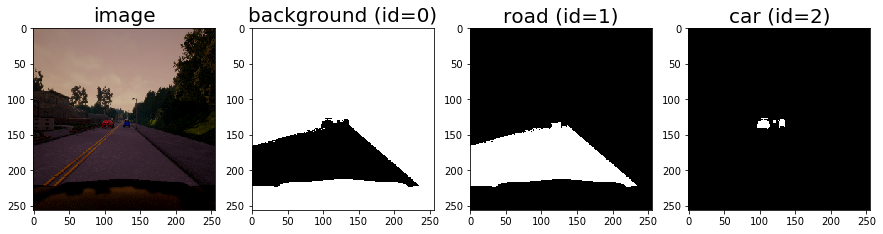

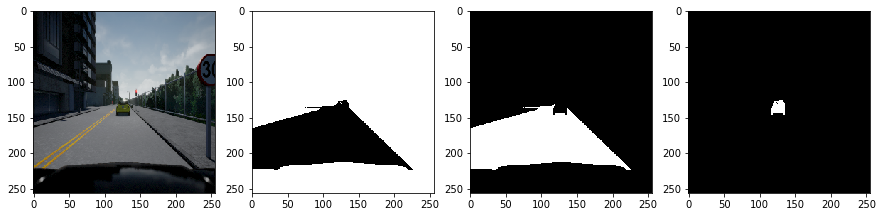

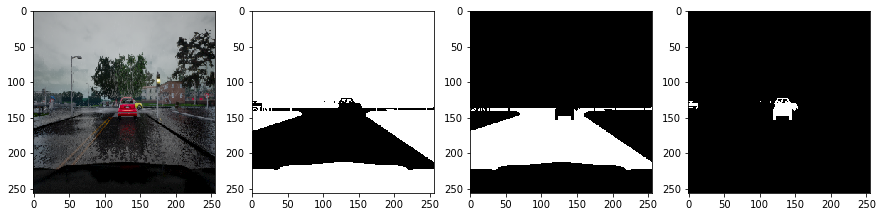

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from glob import glob
from helper5 import remove_hood, remap_seg, seg2labels

TRAINING_DIR = '../lyft_training_data/Train/'
RGB_DIR = 'CameraRGB'
SEG_DIR = 'CameraSeg'

# 0: nothing, 1: road + roadlines, 2: vehicles
SEG_MAP = {
    6: 1, 7: 1,
    10: 2
}
AOI_PERC = 0.83

# height, width
IMG_SIZE = (256, 256)

rgb_paths = glob(os.path.join(TRAINING_DIR, RGB_DIR, '*.png'))
seg_paths = glob(os.path.join(TRAINING_DIR, SEG_DIR, '*.png'))
random_ids = np.random.permutation(len(rgb_paths))

for i in range(3):
    
    rgb_file = rgb_paths[random_ids[i]]
    seg_file = seg_paths[random_ids[i]]
    
    rgb = cv2.imread(rgb_file, cv2.IMREAD_COLOR)

    rgb = cv2.cvtColor(cv2.imread(rgb_file), cv2.COLOR_BGR2RGB)
    seg = remove_hood(cv2.imread(seg_file, cv2.IMREAD_COLOR)[:, :, 2],
                      perc_retain=AOI_PERC)
    # rgb, seg = data_augmentation(rgb, seg, args)
    rgb = cv2.resize(rgb,
                     (IMG_SIZE[1], IMG_SIZE[0]))

    seg = cv2.resize(seg,
                     (IMG_SIZE[1], IMG_SIZE[0]),
                     interpolation=cv2.INTER_NEAREST)
    seg = remap_seg(seg, SEG_MAP)

    labels = seg2labels(seg)
    seg = seg * 100

    plt.figure(figsize=(15,15))
    plt.subplot(241), plt.imshow(rgb)
    if i == 0:
        plt.title('image', fontsize=20)
    plt.subplot(242), plt.imshow(labels[:, :, 0], cmap='gray')
    if i == 0:
        plt.title('background (id=0)', fontsize=20)
    plt.subplot(243), plt.imshow(labels[:, :, 1], cmap='gray')
    if i == 0:
        plt.title('road (id=1)', fontsize=20)
    plt.subplot(244), plt.imshow(labels[:, :, 2], cmap='gray')
    if i == 0:
        plt.title('car (id=2)', fontsize=20)
    plt.show()

### 2.2. Data Augmentation

I augmented the data by running three operations at random to the training data:

1. Horizontal flip
2. Brightness between -0.1 to +8.0
3. Rotation between -1.0 to +1.0 degrees

Here are the images on both extremes:

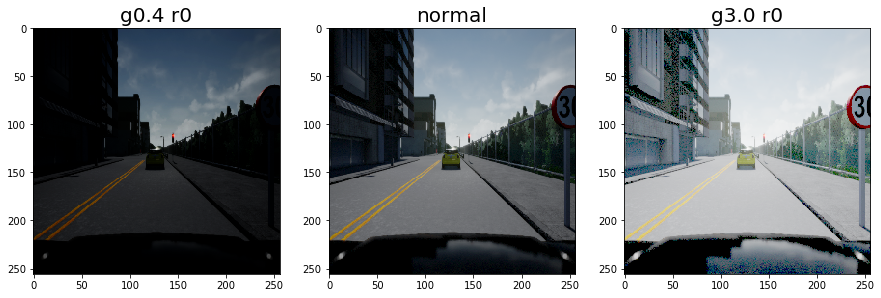

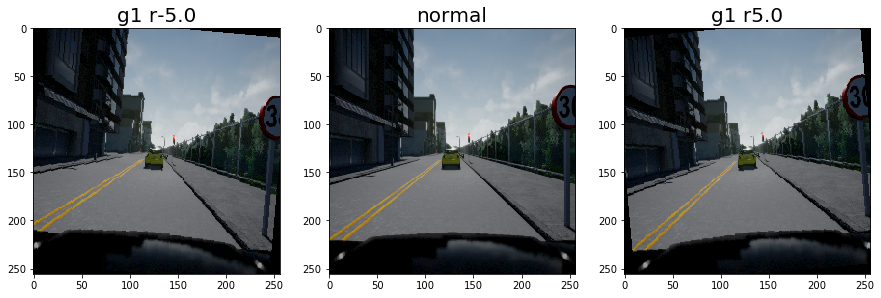

In [8]:
min_brightness = 0.4
max_brightness = 3.0
min_rotate = -5.0
max_rotate = 5.0

rgb = cv2.imread(rgb_paths[random_ids[1]], cv2.IMREAD_COLOR)
rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)

seg = cv2.imread(seg_paths[random_ids[0]], cv2.IMREAD_COLOR)
seg = cv2.cvtColor(seg, cv2.COLOR_BGR2RGB)

rgb = cv2.resize(rgb,
                 (IMG_SIZE[1], IMG_SIZE[0]))

seg = cv2.resize(seg,
                 (IMG_SIZE[1], IMG_SIZE[0]),
                 interpolation=cv2.INTER_NEAREST)

def adj_brightness(input_image, gamma):
    if gamma == 0:
        gamma = 0.01
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype(np.uint8)
    return cv2.LUT(input_image, table)

def rotate(input_image, angle):
    M = cv2.getRotationMatrix2D((input_image.shape[1]//2, input_image.shape[0]//2), angle, 1.0)
    return cv2.warpAffine(input_image, M, (input_image.shape[1], input_image.shape[0]), flags=cv2.INTER_NEAREST)
    
def augment(input_image, brightness, rotation):
    img = adj_brightness(input_image, brightness)
    img = rotate(img, rotation)
    return img

plt.figure(figsize=(15,15))
plt.subplot(131), plt.imshow(augment(rgb, min_brightness, 0))
plt.title('g{} r{}'.format(min_brightness, 0), fontsize=20)

plt.subplot(132), plt.imshow(rgb)
plt.title('normal', fontsize=20)

plt.subplot(133), plt.imshow(augment(rgb, max_brightness, 0))
plt.title('g{} r{}'.format(max_brightness, 0), fontsize=20)

plt.show()

plt.figure(figsize=(15,15))
plt.subplot(131), plt.imshow(augment(rgb, 1, min_rotate))
plt.title('g{} r{}'.format(1, min_rotate), fontsize=20)

plt.subplot(132), plt.imshow(rgb)
plt.title('normal', fontsize=20)

plt.subplot(133), plt.imshow(augment(rgb, 1, max_rotate))
plt.title('g{} r{}'.format(1, max_rotate), fontsize=20)

plt.show()

After running the training for 69 epochs, I noticed that in some scenes, images with 0.1 brightness consistently had bad performance (i.e.cross-entropy loss > 0.1). The images turned out to be too dark. Hence, I updated the minimum brightness to 0.2 before training further batches. In addition, I updated the rotation range to be 2 degrees.


## Training Configurations

The training was set up to run for 54 epochs with the batch size of 1. Loss function used was Cross-Entropy.


## Post Processing

There are two main post processing steps that were done:

1. Since the grader gives more importance to Recall of car segmentation, I dilated the result with a 3x3 kernel.
2. Resize the image to the original size of 800 x 600 pixels.

Here are some example results before and after dilation. Note that these results were taken by running inference on unseen data:

In [187]:
%%capture

import tensorflow as tf
from glob import glob
import os.path
import cv2
import scipy.misc
import numpy as np
import matplotlib.pyplot as plt

TEST_DIR = '../lyft_training_data/Test/new_data/episode_0001'
MODEL_DIR = 'saved_models/2018-05-26-1309'
IMG_SIZE = (256, 256)

def reshape_to_ori(mask, ori_img_shape):
    scale_height = int(ori_img_shape[0])
    scale_width = int(ori_img_shape[1])
    mask = np.array(mask, dtype=np.uint8)
    mask = cv2.resize(mask, (scale_width, scale_height), interpolation=cv2.INTER_NEAREST)
    return mask

def draw_answer(rgb_frame, seg_car, seg_road):
    street_im = scipy.misc.toimage(rgb_frame)
    seg_car = seg_car.reshape(rgb_frame.shape[0], rgb_frame.shape[1], 1)
    seg_road = seg_road.reshape(rgb_frame.shape[0], rgb_frame.shape[1], 1)
    
    mask = np.dot(seg_road, np.array([[0, 255, 0, 127]])) + \
           np.dot(seg_car, np.array([[255, 0, 0, 127]]))

    mask = scipy.misc.toimage(mask, mode="RGBA")

    street_im.paste(mask, box=None, mask=mask)
    street_im = scipy.misc.fromimage(street_im)
    return street_im

# https://stackoverflow.com/questions/33759623/tensorflow-how-to-save-restore-a-model/47235448#47235448

sess = tf.Session()
signature_key = tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY

meta_graph_def = tf.saved_model.loader.load(sess,
                                            [tf.saved_model.tag_constants.SERVING], MODEL_DIR)

image_input = sess.graph.get_tensor_by_name('net_input:0')
logits = sess.graph.get_tensor_by_name('logits_1:0')

rgb_paths = glob(os.path.join(TEST_DIR, RGB_DIR, '*.png'))
random_ids = np.random.permutation(len(rgb_paths))

results = []

for i in range(3):
    img_path = rgb_paths[random_ids[i]]
    rgb_frame = cv2.imread(img_path)
    rgb_frame = cv2.cvtColor(rgb_frame, cv2.COLOR_BGR2RGB)

    image = cv2.resize(rgb_frame, (IMG_SIZE[1], IMG_SIZE[0]))

    output_image = sess.run(
        logits, feed_dict={image_input: [image]})

    output_image = np.array(output_image[0,:,:,:])
    im_softmax_road = output_image[:, :, 1]
    im_softmax_vehicle = output_image[:, :, 2]

    seg_road = \
      ((im_softmax_road >= 0.50) & (im_softmax_road >= im_softmax_vehicle))
        
    seg_vehicle = \
      ((im_softmax_vehicle >= 0.50) & (im_softmax_vehicle >= im_softmax_road))

    # Dilation
    kernel = np.ones((3,3), np.uint8)
    seg_vehicle = np.array(seg_vehicle, dtype=np.uint8)
    seg_vehicle_w_dil = cv2.dilate(seg_vehicle, kernel, iterations=1)

    seg_road_w_dil = (seg_road) & (seg_road != seg_vehicle_w_dil)

    seg_road = reshape_to_ori(seg_road, rgb_frame.shape)
    seg_vehicle = reshape_to_ori(seg_vehicle, rgb_frame.shape)

    seg_road_w_dil = reshape_to_ori(seg_road_w_dil, rgb_frame.shape)
    seg_vehicle_w_dil = reshape_to_ori(seg_vehicle_w_dil, rgb_frame.shape)
    
    print(seg_road_w_dil.shape)

    results.append((draw_answer(rgb_frame, seg_vehicle, seg_road),
                    draw_answer(rgb_frame, seg_vehicle_w_dil, seg_road_w_dil)))

INFO:tensorflow:Restoring parameters from b'saved_models/2018-05-26-1309/variables/variables'


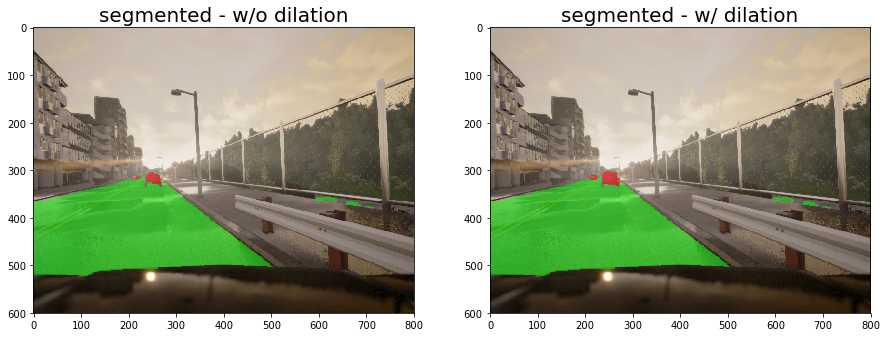

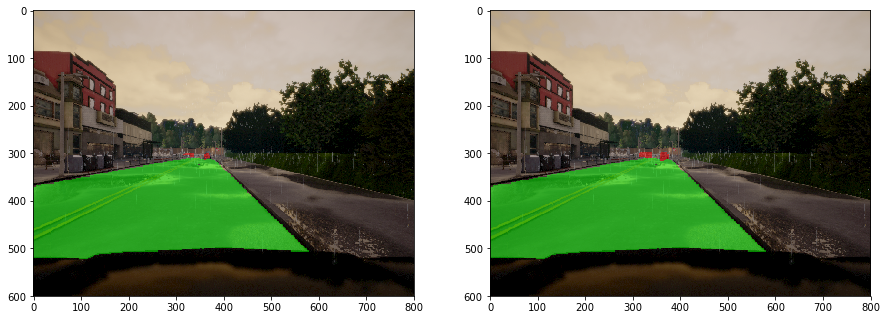

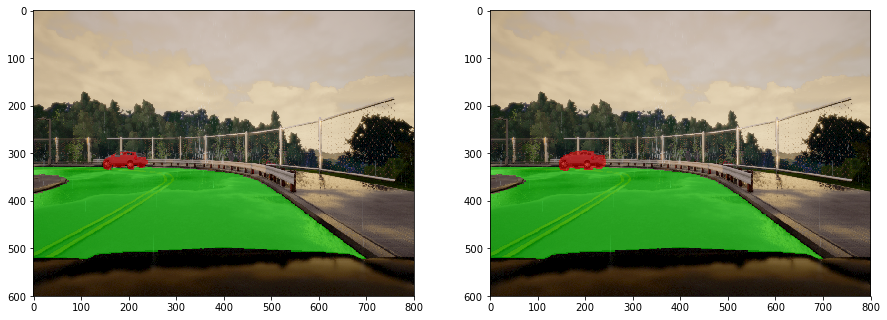

In [189]:
for i, img in enumerate(results):
    img_path = rgb_paths[random_ids[i]]
    rgb_frame = cv2.imread(img_path)
    rgb_frame = cv2.cvtColor(rgb_frame, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(15,10))
    plt.subplot(121), plt.imshow(img[0])
    if i == 0:
        plt.title('segmented - w/o dilation', fontsize=20)
    
    plt.subplot(122), plt.imshow(img[1])
    if i == 0:
        plt.title('segmented - w/ dilation', fontsize=20)

## 3. Speed Optimizations

Some optimizations were made to increase the inference speed:

1. I used OpenCV (cv2-python) module to encode images instead of PIL.
2. OpenCV was used to read data from video too using `cv2.VideoCapture` function.
3. [Freeze](http://cv-tricks.com/how-to/freeze-tensorflow-models/) the model and use the frozen model for inference.

Prior to these optimizations, the inference performance was around 6.3, then increased to around 9.5 after I have done the first and second adjustments, and finally improved to 11.4 after the last adjustment. 

## References

1. <a id="ref1">[Akira Sosa, MobileUNet code (https://github.com/akirasosa/mobile-semantic-segmentation).](https://github.com/akirasosa/mobile-semantic-segmentation)</a>
2. <a id="ref2">[Andrew G. Howard, Menglong Zhu, Bo Chen, Dmitry Kalenichenko, Weijun Wang, Tobias Weyand, Marco Andreetto, Hartwig Adam, MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications, April 2017.](https://arxiv.org/abs/1704.04861)</a>
3. <a id="ref3">[Olaf Ronneberger, Philipp Fischer, Thomas Brox, Medical Image Computing and Computer-Assisted Intervention (MICCAI), Springer, LNCS, Vol.9351: 234--241, 2015.](https://lmb.informatik.uni-freiburg.de/Publications/2015/RFB15a/)</a>